# 2MASS-J19432996+5059289

In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import lightkurve as lk
from glob import glob
import ombre as om
import numpy as np
import matplotlib.pyplot as plt
import astropy.units as u
import pymc3_ext as pmx

In [3]:
name = '2MASS-J19432996+5059289'

In [4]:
period = 365.48928488
t0 = 485.828487947204 + 2454833
duration = 0.38*24

<AxesSubplot:xlabel='Phase [JD]', ylabel='Normalized Flux'>

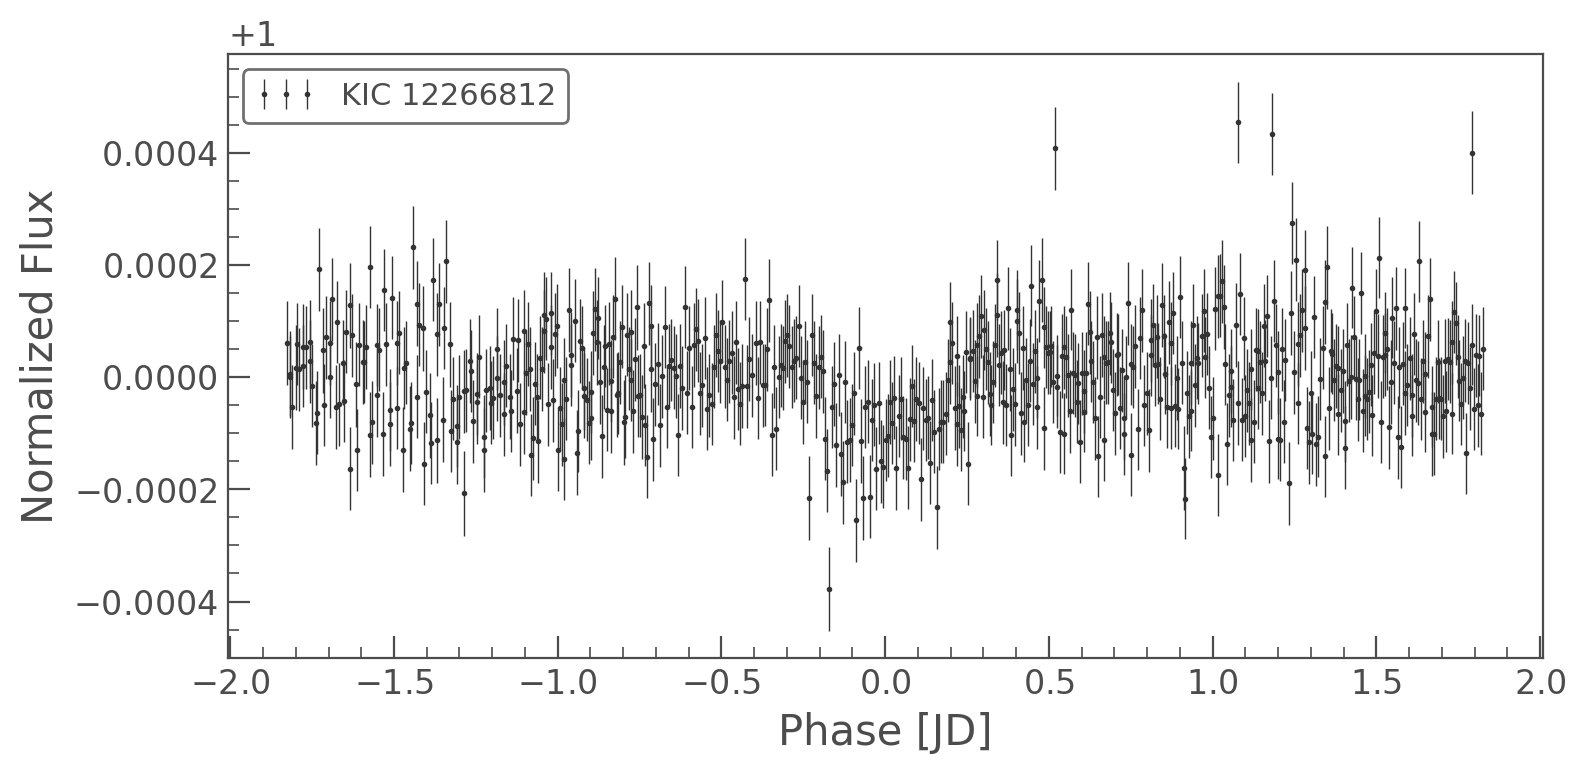

In [200]:
sr = lk.search_lightcurve('KIC 12266812', mission='kepler')
clc = sr.download_all().stitch().remove_nans().flatten(201)
clc.flux = clc.flux.value * u.electron/u.s
clc.flux_err = clc.flux_err.value * u.electron/u.s
k = np.abs(((clc.time.value - (t0 - 2454833 + period/2))/period) % 1 - 0.5) < 0.005
clc -= np.median(clc[k].flux) - 1*clc.flux.unit
clc[k].fold(period, t0 - 2454833).errorbar(marker='.')

In [6]:
fnames = np.asarray(glob(f'/Volumes/Nibelheim/hst/data/{name}/*.fits'))

In [188]:
obs = om.Observation.from_files(fnames, force=True)

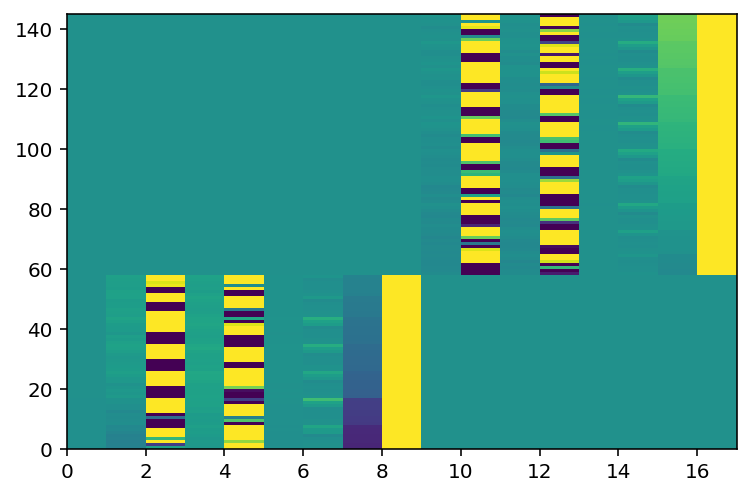

In [201]:
plt.pcolormesh(obs[0].A, vmin=-1, vmax=1)

In [202]:
obs.period = period
obs.t0 = t0
obs.radius = 1*u.earthRad.to(u.solRad)
obs.duration = duration
obs.incl = 90
obs.st_rad = 1
obs.st_mass = 1
obs.st_teff = 5800

In [203]:
obs.fit_transit(x_suppl=clc.time.value[k] + 2454833,
                y_suppl=clc.flux.value[k],
                yerr_suppl=clc.flux_err.value[k],
                exptime_suppl=np.median(np.diff(clc.time.value)), fit_period=True, fit_t0=True, fit_inc=True, calc_eclipse=False, u_suppl=[0.44, 0.23])

In [204]:
from astropy.stats import sigma_clip

In [205]:
good = ~sigma_clip((clc[k].flux.value - (obs.map_soln['transit_suppl'] + 1)), sigma=2).mask
good_times = np.ones_like(k)
good_times[k] = good

In [206]:
obs.fit_transit(x_suppl=clc.time.value[k & good_times] + 2454833,
                y_suppl=clc.flux.value[k & good_times],
                yerr_suppl=clc.flux_err.value[k & good_times],
                exptime_suppl=np.median(np.diff(clc.time.value)), fit_period=True, fit_t0=True, fit_inc=True, calc_eclipse=False, u_suppl=[0.44, 0.23])

/Users/ch/Library/Caches/pypoetry/virtualenvs/ombre-vf38qw1p-py3.8/lib/python3.8/site-packages/lightkurve/lightcurve.py:936: LightkurveWarning: `epoch_time` appears to be given in JD, however the light curve time uses BKJD (i.e. JD - 2454833).
  warnings.warn(


<AxesSubplot:xlabel='Phase [JD]', ylabel='Flux'>

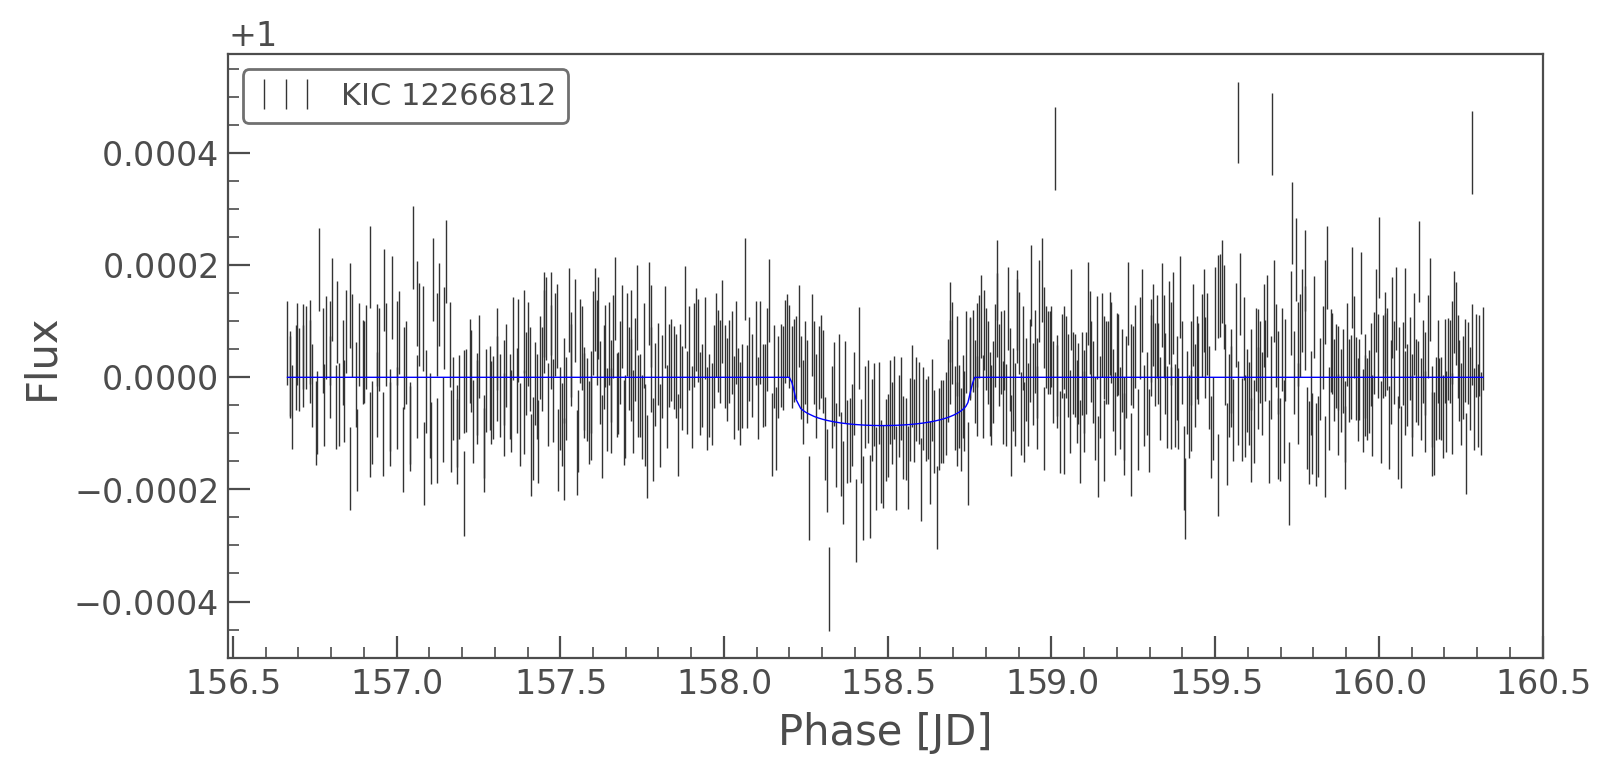

In [207]:
ax = clc[k].fold(obs.period, obs.t0).errorbar()
lk.LightCurve(time=clc.time[k & good_times].value, flux=obs.map_soln['transit_suppl'] + 1).fold(obs.period, obs.t0).plot(ax=ax, c='b')

<AxesSubplot:xlabel='Phase', ylabel='$e^-s^{-1}$'>

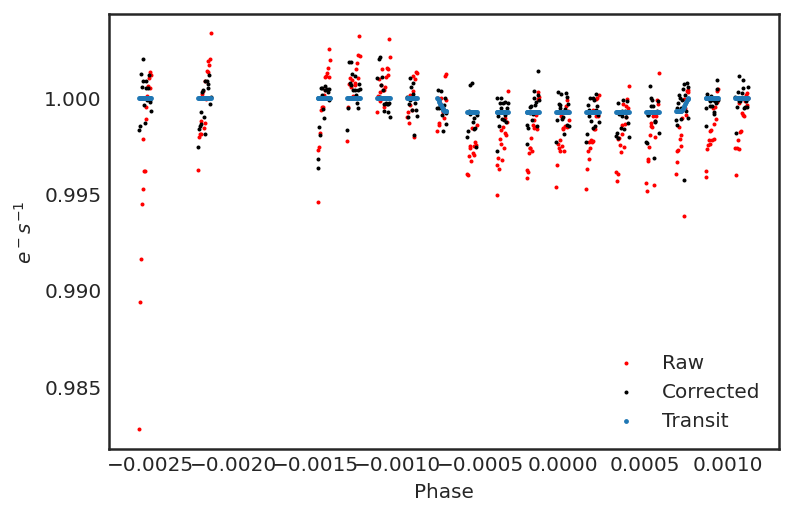

In [208]:
obs.plot()

In [22]:
import pymc3_ext as pmx

In [23]:
with obs._pymc3_model:
    trace = pmx.sample(
        draws=1000,
        tune=1000,
        start=obs.map_soln,
        chains=2,
        cores=4,
        target_accept=0.95,
        return_inferencedata=True,
    )

Multiprocess sampling (2 chains in 4 jobs)
NUTS: [r_suppl, inc, r, m_star, r_star, u, period, t0, norm_suppl]


ValueError: Not enough samples to build a trace.

In [24]:
import arviz as az

In [25]:
_ = az.plot_trace(trace, var_names=["r", "r_suppl", "inc"])

NameError: name 'trace' is not defined

In [ ]:
from corner import corner

In [ ]:
corner(trace, var_names=['r', 'r_suppl'], labels=['r$_{WFC3}$', 'r$_{Kepler}$']);
plt.savefig('kic12266812_corner.png', dpi=150, bbox_inches='tight')

In [ ]:
plt.errorbar(
                obs.phase,
                obs.average_lc,
                obs.average_lc_err,
                c="red",
                ls='',
                label='Raw',
                lw=0.5
            )

y = obs.average_lc / obs.map_soln["noise_model"]
ye = obs.average_lc_err / obs.map_soln["noise_model"]
plt.errorbar(
                obs.phase,
                y,
                ye,
                c="k",
                ls='',
    marker='.',
    ms=3,
    label='Corrected'
            )
plt.plot(obs.phase, np.median(y[obs.oot]) * (np.vstack(trace.posterior['transit']).T + 1)[:, ::10], alpha=0.1, marker='.', ls='', c='blue', ms=2);
plt.legend()
plt.ylim(199.5, 201.5)
plt.xlabel('Phase')
plt.ylabel('WFC3 Flux')
plt.title('KIC 12266812 HST')
plt.savefig('kic12266812.png', dpi=150, bbox_inches='tight')

In [ ]:
f = clc[k].fold(obs.period, obs.t0)

In [ ]:
ph = (clc[k& good_times].time.value - t0 + 2454833 - period/2)/period % 1 - 0.5
s = np.argsort(ph)
plt.errorbar(ph[s], clc.flux[k & good_times][s].value, clc.flux_err[k& good_times][s].value, c='k', zorder=1, ls='', lw=1);
plt.plot(ph[s], np.vstack(trace.posterior['transit_suppl'].data).T[s][:, ::100] + 1, c='b', zorder=10);
plt.xlabel('Phase')
plt.ylabel('WFC3 Flux')
plt.title('KIC 12266812 Kepler')
plt.savefig('kic12266812_kepler.png', dpi=150, bbox_inches='tight')

/Users/ch/Library/Caches/pypoetry/virtualenvs/ombre-vf38qw1p-py3.8/lib/python3.8/site-packages/lightkurve/lightcurve.py:936: LightkurveWarning: `epoch_time` appears to be given in JD, however the light curve time uses BKJD (i.e. JD - 2454833).
  warnings.warn(


<AxesSubplot:xlabel='Phase [JD]', ylabel='Flux'>

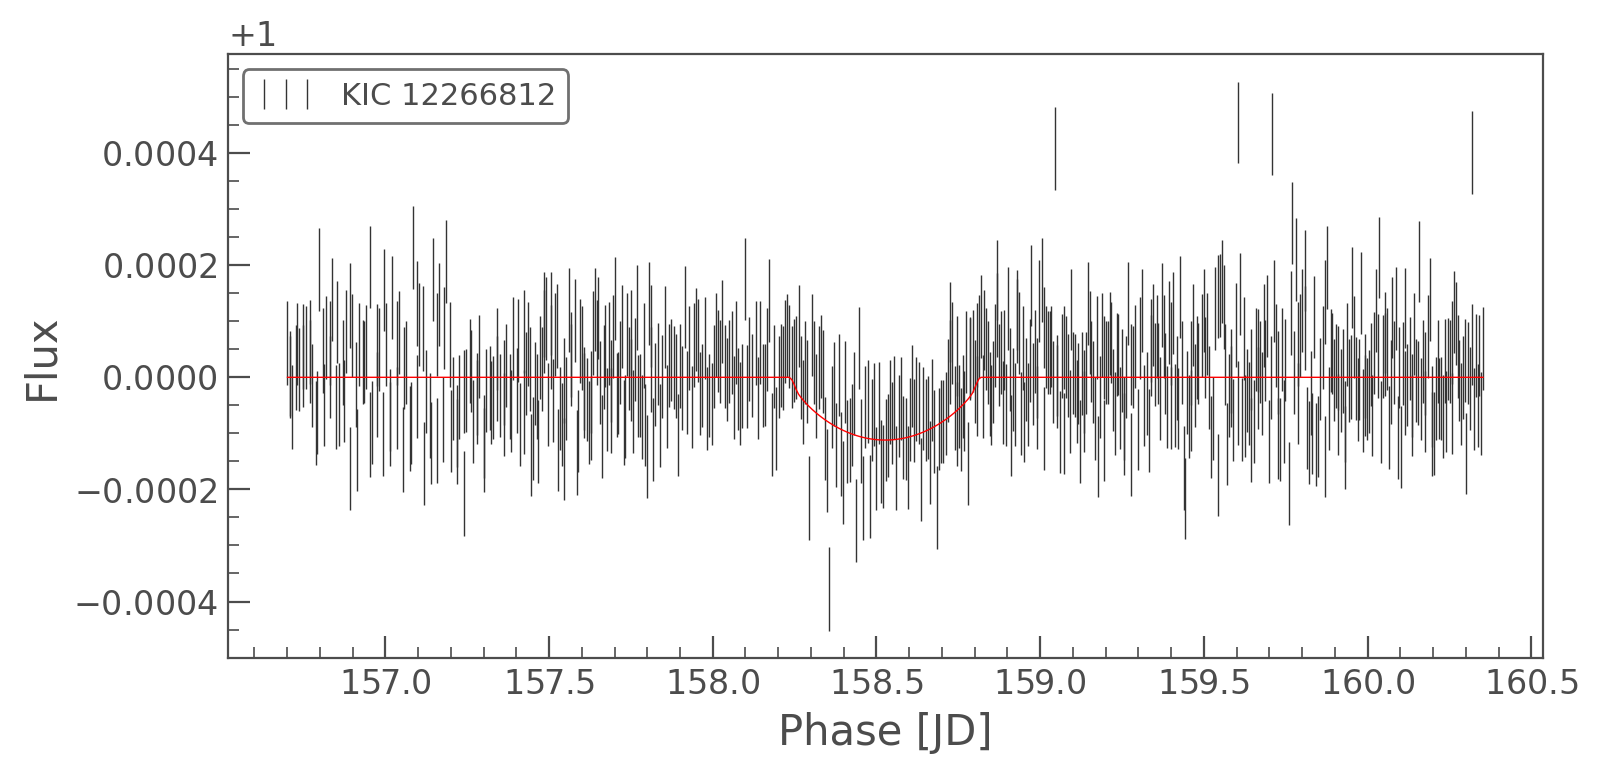

In [213]:
ax = clc[k].fold(obs.period, obs.t0).errorbar()
lk.LightCurve(time=clc.time[k].value, flux=obs.map_soln['transit_suppl'] + 1).fold(obs.period, obs.t0).plot(ax=ax, c='r')

In [208]:
from astropy.time import Time

In [212]:
Time(obs.time[0], format='jd').isot

'2019-05-03T18:50:06.845'

In [108]:
obs.map_soln

{'norm_suppl': array([1.00001261]),
 'u_suppl_quadlimbdark__': array([1.02625195, 0.97420104]),
 'u_quadlimbdark__': array([-2.56867743, -3.71881106]),
 'r_star': array(0.98610643),
 'm_star': array(1.00970112),
 'r_interval__': array(-0.7572211),
 'inc': array(1.57079633),
 'r_suppl_interval__': array(-2.40478644),
 'u_suppl': array([ 1.24576143, -0.38774708]),
 'u': array([0.0126399 , 0.25415908]),
 'r': array(0.02989258),
 'ror': array(0.03031374),
 'transit': array([ 0.00000000e+00,  0.00000000e+00,  0.00000000e+00,  0.00000000e+00,
         0.00000000e+00,  0.00000000e+00,  0.00000000e+00,  0.00000000e+00,
         0.00000000e+00,  0.00000000e+00,  0.00000000e+00,  0.00000000e+00,
         0.00000000e+00,  0.00000000e+00,  0.00000000e+00,  0.00000000e+00,
         0.00000000e+00,  0.00000000e+00,  0.00000000e+00,  0.00000000e+00,
         0.00000000e+00,  0.00000000e+00,  0.00000000e+00,  0.00000000e+00,
         0.00000000e+00,  0.00000000e+00,  0.00000000e+00,  0.00000000e+00,
 

/Users/ch/Library/Caches/pypoetry/virtualenvs/ombre-vf38qw1p-py3.8/lib/python3.8/site-packages/lightkurve/lightcurve.py:936: LightkurveWarning: `epoch_time` appears to be given in JD, however the light curve time uses BKJD (i.e. JD - 2454833).
  warnings.warn(


<AxesSubplot:xlabel='Phase [JD]', ylabel='Flux'>

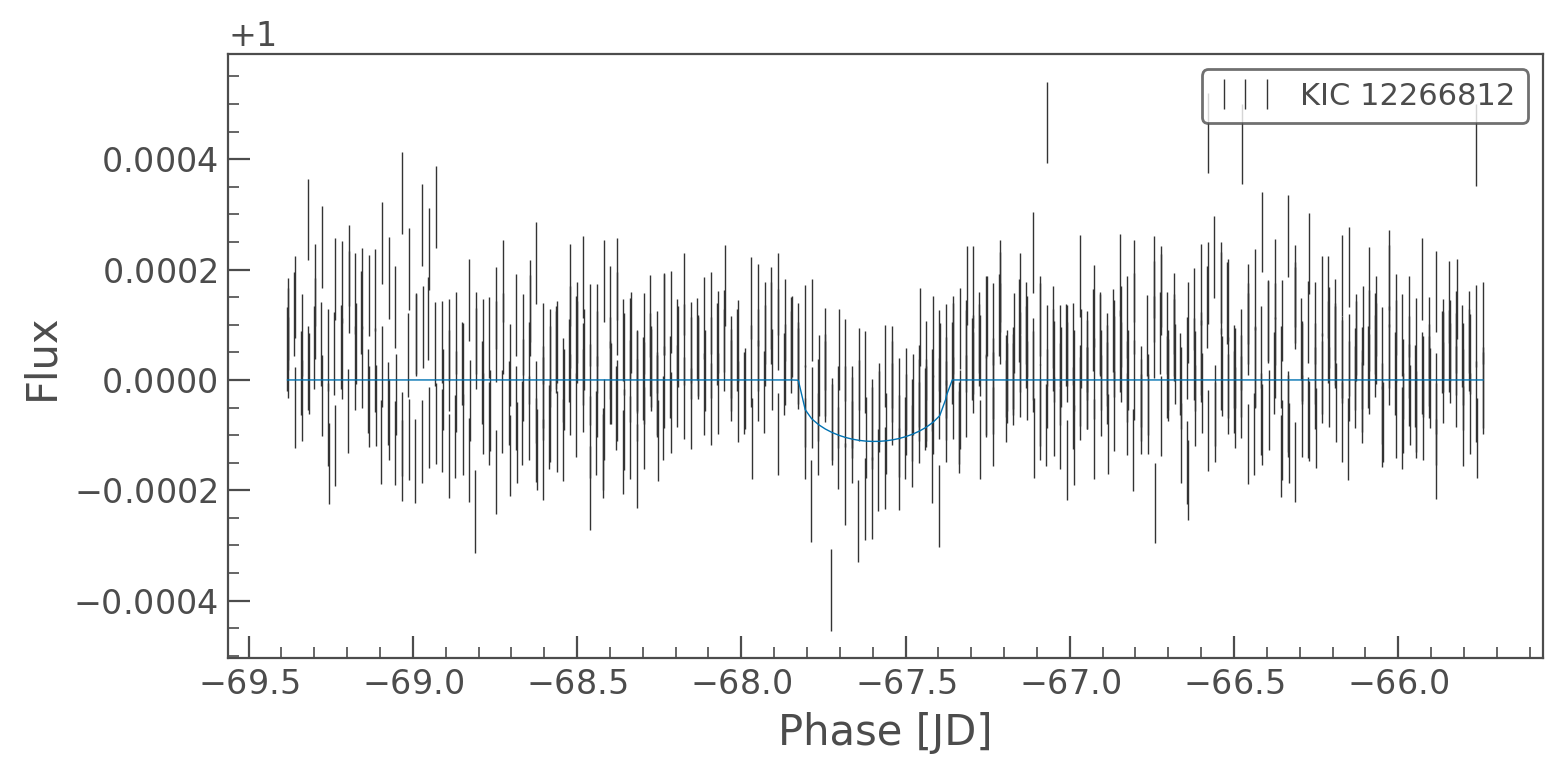

In [116]:
ax = clc[k].fold(obs.period, obs.t0).errorbar()
lk.LightCurve(time=clc.time[k].value, flux=obs.map_soln['transit_suppl'] + 1).fold(obs.period, obs.t0).plot(ax=ax)

In [128]:
v.fit_transit(fit_t0=True, fit_period=True)

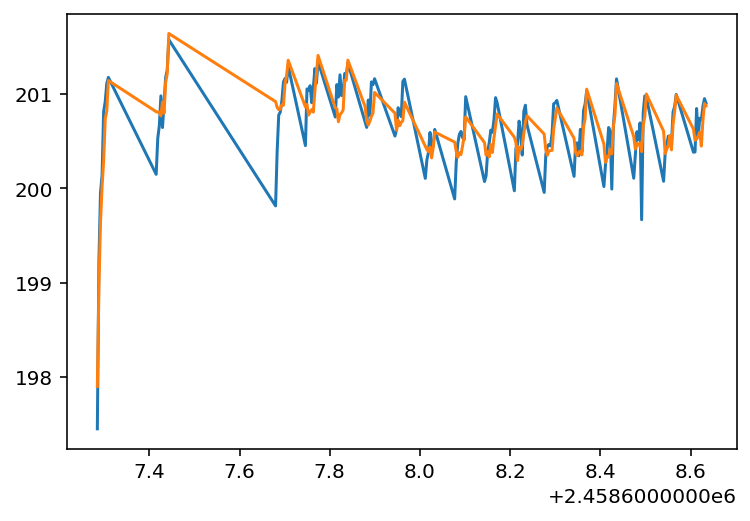

In [129]:
plt.plot(v.time, v.average_lc)
plt.plot(v.time, v.average_lc.mean() * v.map_soln['noise_model'])

In [169]:
from astropy.stats import sigma_clip

In [183]:
shift_check = np.hypot(np.diff(xshift), np.diff(yshift))
shifted = sigma_clip(shift_check, sigma=5).mask
if shifted.sum() == 1:
    break_point = np.where(shifted)[0][0] + 1

In [202]:
A2 = np.zeros((A.shape[0], A.shape[1]*2))
A2[:break_point, :A.shape[1]] = A[:break_point]
A2[break_point:, A.shape[1]:] = A[break_point:]

array([[-0.12875274,  0.05639395, -0.00726088, ...,  0.        ,
         0.        ,  0.        ],
       [-0.12827836,  0.06557524, -0.00841188, ...,  0.        ,
         0.        ,  0.        ],
       [-0.13325492,  0.07362464, -0.00981085, ...,  0.        ,
         0.        ,  0.        ],
       ...,
       [ 0.        ,  0.        ,  0.        , ...,  0.3077381 ,
         0.55474147,  1.        ],
       [ 0.        ,  0.        ,  0.        , ...,  0.31162857,
         0.55823702,  1.        ],
       [ 0.        ,  0.        ,  0.        , ...,  0.31554307,
         0.56173221,  1.        ]])

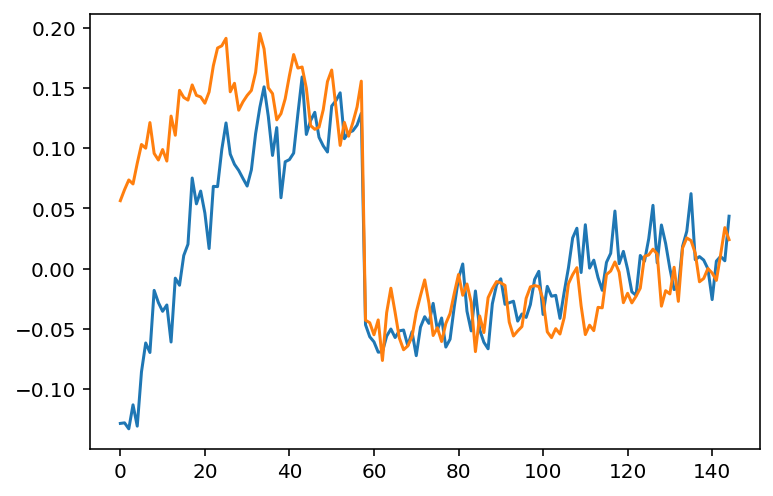

In [138]:
plt.plot(xshift)
plt.plot(yshift)

<AxesSubplot:xlabel='Time [JD]', ylabel='$e^-s^{-1}$'>

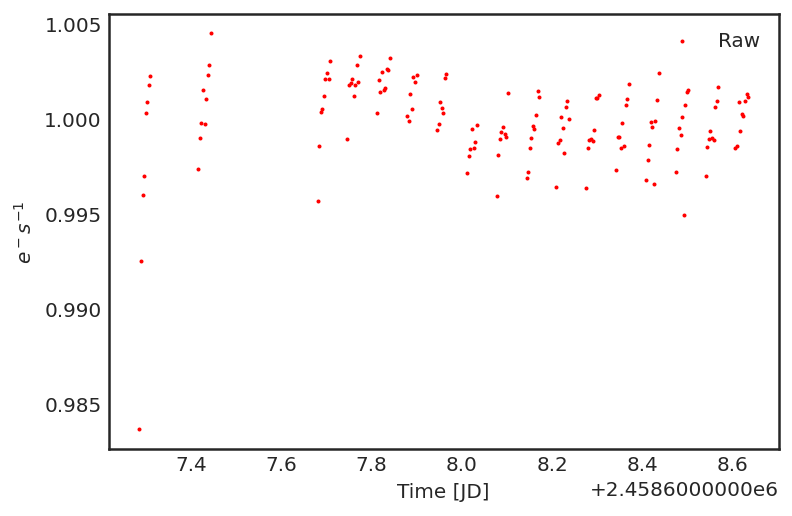

In [97]:
v.plot()

In [ ]:
obs.plot()

In [82]:
from ombre.methods import animate

/Users/ch/HST/projects/ombre/src/ombre/methods.py:56: MatplotlibDeprecationWarning: You are modifying the state of a globally registered colormap. This has been deprecated since 3.3 and in 3.6, you will not be able to modify a registered colormap in-place. To remove this warning, you can make a copy of the colormap first. cmap = mpl.cm.get_cmap("Greys_r").copy()
  cmap.set_bad("black")


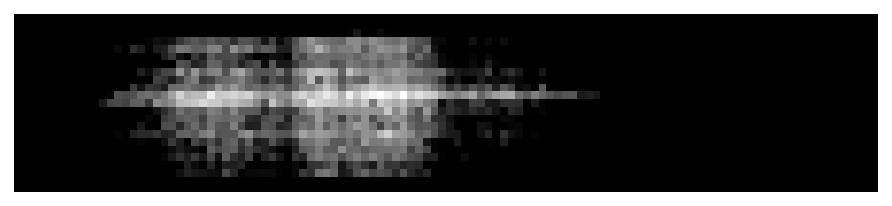

In [83]:
animate(data)

In [ ]:
obs

In [ ]:
obs.plot()

In [4]:
clc = lk.search_lightcurve(name, author='SPOC', exptime=120).download_all().stitch().remove_nans()
clc.flux = clc.flux.value * u.electron/u.s
clc.flux_err = clc.flux.value * u.electron/u.s

In [5]:
k = np.abs(((clc.time.value - (obs.t0 - 2457000 + obs.period/2))/obs.period) % 1 - 0.5) < 0.1
clc[k].fold(obs.period, obs.t0 - 2457000).scatter()

NameError: name 'obs' is not defined

In [ ]:
obs.fit_transit(x_suppl=clc.time.value[k] + 2457000,
                y_suppl=clc.flux.value[k],
                yerr_suppl=clc.flux_err.value[k],
                exptime_suppl=np.median(np.diff(clc.time.value)), fit_t0=True, fit_period=True, fit_inc=True)

In [ ]:
obs.plot()

In [ ]:
obs.fit_model()

In [ ]:
spec = obs.stellar_spectra
spec.plot()
spec.hdulist.writeto(f'results/{name}_stellar_spectrum.fits', overwrite=True)

In [ ]:
obs.plot_spectra()

In [ ]:
ax = om.Spectra([visit.transmission_spectrum for visit in obs]).flatten().bin(bins=np.linspace(0.8, 1.7, 150)).plot()
ax.set(title='WASP-107 Transmission Spectrum')

In [ ]:
from astropy.io import fits
try:
    hdulist = om.Spectra([visit.transmission_spectrum for visit in obs if visit.transmission_spectrum.spec.sum() != 0]).hdulist
    hdulist.writeto(f'results/{name}_transmission.fits')
except:
    pass
try:    
    hdulist = om.Spectra([visit.emission_spectrum for visit in obs if visit.emission_spectrum.spec.sum() != 0]).hdulist
    hdulist.writeto(f'results/{name}_emission.fits')
except:
    pass

In [ ]:
for visit in obs:
    visit.diagnose();
    plt.show();